In [23]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import metrics
import pandas_datareader.data as web
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [24]:
#Read stock data use pandas_datareader.data from web
# Get Stock Data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [25]:
# Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data
print(X1)
print(X2)
print(X3)

Attributes   Adj Close            
Symbols          GOOGL         IBM
Date                              
2017-09-18   46.487499  108.947281
2017-09-19   46.842999  108.826698
2017-09-20   47.376999  109.949707
2017-09-21   47.377499  109.482422
2017-09-22   47.162998  109.384407
...                ...         ...
2022-09-09  110.650002  129.190002
2022-09-12  110.860001  130.660004
2022-09-13  104.320000  127.250000
2022-09-14  105.000000  127.690002
2022-09-15  102.910004  125.489998

[1258 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-09-18   111.48   1.3485
2017-09-19   111.49   1.3517
2017-09-20   111.50   1.3564
2017-09-21   112.30   1.3576
2017-09-22   112.01   1.3531
...             ...      ...
2022-09-05      NaN      NaN
2022-09-06   142.95   1.1549
2022-09-07   144.39   1.1473
2022-09-08   144.05   1.1489
2022-09-09   142.44   1.1600

[1300 rows x 2 columns]
              SP500      DJIA  VIXCLS
DATE                                 
2017-09

In [26]:
#Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = preprocessing.StandardScaler()
sX1 = standard_scaler.fit_transform(X1.values)
sX2 = standard_scaler.fit_transform(X2.values)
sX3 = standard_scaler.fit_transform(X3.values)
print(type(sX1))
sX1

<class 'numpy.ndarray'>


array([[-1.15774649, -0.59674325],
       [-1.14650867, -0.6078857 ],
       [-1.12962818, -0.50411389],
       ...,
       [ 0.6704188 ,  1.09452258],
       [ 0.69191455,  1.13518108],
       [ 0.62584688,  0.93188929]])

In [27]:
sX1 = pd.DataFrame(index = X1.index,data = sX1,columns=X1.columns)
sX2 = pd.DataFrame(index = X2.index,data = sX2,columns=X2.columns)
sX3 = pd.DataFrame(index = X3.index,data = sX3,columns=X3.columns)
sX1

Attributes Adj Close          
Symbols        GOOGL       IBM
Date                          
2017-09-18 -1.157746 -0.596743
2017-09-19 -1.146509 -0.607886
2017-09-20 -1.129628 -0.504114
2017-09-21 -1.129612 -0.547293
2017-09-22 -1.136393 -0.556351
...              ...       ...
2022-09-09  0.870519  1.273789
2022-09-12  0.877157  1.409625
2022-09-13  0.670419  1.094523
2022-09-14  0.691915  1.135181
2022-09-15  0.625847  0.931889

[1258 rows x 2 columns]

In [28]:
X1['Adj Close']

Symbols,GOOGL,IBM
Date,,
2017-09-18,46.487499,108.947281
2017-09-19,46.842999,108.826698
2017-09-20,47.376999,109.949707
2017-09-21,47.377499,109.482422
2017-09-22,47.162998,109.384407
...,...,...
2022-09-09,110.650002,129.190002
2022-09-12,110.860001,130.660004
2022-09-13,104.320000,127.250000


In [29]:
# Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง return_period วัน
return_period = 1 #predict 1 วันข้างหน้า
Y = base.shift(-return_period)
X4_3DT = base.diff(3*return_period).shift(-3*return_period)
X4_6DT = base.diff(6*return_period).shift(-6*return_period)
X4_12DT = base.diff(12*return_period).shift(-12*return_period)
X4 = pd.concat([X4_3DT, X4_6DT, X4_12DT], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

# Forming Dataset
X = pd.concat([sX1, sX2, sX3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)
print(type(dataset))


<class 'pandas.core.frame.DataFrame'>


In [30]:
dataset.dropna(inplace=True)
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-09-18,70.887177,-1.157746,-0.596743,-0.034125,0.632440,-1.266457,-1.503384,-1.182579,-0.231712,-0.342111,-0.209739
2017-09-19,70.417336,-1.146509,-0.607886,-0.032778,0.687607,-1.262425,-1.493851,-1.179130,-0.244900,-0.304913,-0.122156
2017-09-20,69.731415,-1.129628,-0.504114,-0.031431,0.768632,-1.260119,-1.483753,-1.225117,-0.352024,-0.242510,-0.075736
2017-09-21,69.919334,-1.129612,-0.547293,0.076321,0.789320,-1.271199,-1.496647,-1.237764,-0.231716,-0.080517,0.013595
2017-09-22,68.838737,-1.136393,-0.556351,0.037261,0.711742,-1.268850,-1.498977,-1.246961,-0.167438,-0.090120,-0.003920
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,275.790009,0.971991,1.786638,3.316975,-2.196569,1.089918,1.052826,0.422379,-1.539710,-2.025844,-1.285195
2022-08-24,278.850006,0.966618,1.647105,3.392402,-2.268975,1.107379,1.067237,0.274069,-1.927336,-2.079481,-1.020488
2022-08-25,268.089996,1.060187,1.716409,3.380280,-2.267251,1.191998,1.145181,0.154502,-2.860450,-3.024489,-2.672114
2022-08-26,265.230011,0.860719,1.383751,3.412605,-2.310350,0.986853,0.901508,0.589083,-1.236271,-2.009242,-1.647769


In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1229 entries, 2017-09-18 to 2022-08-29
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1229 non-null   float64
 1   (Adj Close, GOOGL)  1229 non-null   float64
 2   (Adj Close, IBM)    1229 non-null   float64
 3   DEXJPUS             1229 non-null   float64
 4   DEXUSUK             1229 non-null   float64
 5   SP500               1229 non-null   float64
 6   DJIA                1229 non-null   float64
 7   VIXCLS              1229 non-null   float64
 8   MSFT_3DT            1229 non-null   float64
 9   MSFT_6DT            1229 non-null   float64
 10  MSFT_12DT           1229 non-null   float64
dtypes: float64(11)
memory usage: 115.2 KB


In [32]:
Y = pd.DataFrame(dataset[dataset.columns[0]].reset_index(drop=True))
X = pd.DataFrame(dataset[dataset.columns[1:]].reset_index(drop=True))
print(Y)
print(X)

       Adj Close
            MSFT
0      70.887177
1      70.417336
2      69.731415
3      69.919334
4      68.838737
...          ...
1224  275.790009
1225  278.850006
1226  268.089996
1227  265.230011
1228  262.970001

[1229 rows x 1 columns]
      (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK     SP500  \
0              -1.157746         -0.596743 -0.034125  0.632440 -1.266457   
1              -1.146509         -0.607886 -0.032778  0.687607 -1.262425   
2              -1.129628         -0.504114 -0.031431  0.768632 -1.260119   
3              -1.129612         -0.547293  0.076321  0.789320 -1.271199   
4              -1.136393         -0.556351  0.037261  0.711742 -1.268850   
...                  ...               ...       ...       ...       ...   
1224            0.971991          1.786638  3.316975 -2.196569  1.089918   
1225            0.966618          1.647105  3.392402 -2.268975  1.107379   
1226            1.060187          1.716409  3.380280 -2.267251  1.1919

In [33]:
X.corr()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
"(Adj Close, GOOGL)",1.000000,0.601793,0.392870,0.266160,0.985415,0.960172,0.153017,-0.053557,-0.076005,-0.102324
"(Adj Close, IBM)",0.601793,1.000000,0.570644,0.228632,0.608928,0.661023,-0.285608,-0.084682,-0.132809,-0.174050
DEXJPUS,0.392870,0.570644,1.000000,-0.365275,0.350181,0.343815,0.050443,-0.075823,-0.114391,-0.162015
DEXUSUK,0.266160,0.228632,-0.365275,1.000000,0.278266,0.322238,-0.327849,0.004784,0.013394,0.026606
SP500,0.985415,0.608928,0.350181,0.278266,1.000000,0.986195,0.108280,-0.060321,-0.088016,-0.120899
DJIA,0.960172,0.661023,0.343815,0.322238,0.986195,1.000000,-0.005292,-0.062945,-0.091934,-0.123991
VIXCLS,0.153017,-0.285608,0.050443,-0.327849,0.108280,-0.005292,1.000000,0.059809,0.081869,0.109965
MSFT_3DT,-0.053557,-0.084682,-0.075823,0.004784,-0.060321,-0.062945,0.059809,1.000000,0.688943,0.491058
MSFT_6DT,-0.076005,-0.132809,-0.114391,0.013394,-0.088016,-0.091934,0.081869,0.688943,1.000000,0.680495
MSFT_12DT,-0.102324,-0.174050,-0.162015,0.026606,-0.120899,-0.123991,0.109965,0.491058,0.680495,1.000000


In [34]:
lower = pd.DataFrame(np.tril(X.corr(),-1),columns = X.columns)
to_drop = [column for column in lower.columns if any(lower[column] > 0.9)]
to_drop


[('Adj Close', 'GOOGL'), 'SP500']

In [35]:
X.drop(columns=to_drop,inplace=True)


In [36]:
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.596743,-0.034125,0.632440,-1.503384,-1.182579,-0.231712,-0.342111,-0.209739
1,-0.607886,-0.032778,0.687607,-1.493851,-1.179130,-0.244900,-0.304913,-0.122156
2,-0.504114,-0.031431,0.768632,-1.483753,-1.225117,-0.352024,-0.242510,-0.075736
3,-0.547293,0.076321,0.789320,-1.496647,-1.237764,-0.231716,-0.080517,0.013595
4,-0.556351,0.037261,0.711742,-1.498977,-1.246961,-0.167438,-0.090120,-0.003920
...,...,...,...,...,...,...,...,...
1224,1.786638,3.316975,-2.196569,1.052826,0.422379,-1.539710,-2.025844,-1.285195
1225,1.647105,3.392402,-2.268975,1.067237,0.274069,-1.927336,-2.079481,-1.020488
1226,1.716409,3.380280,-2.267251,1.145181,0.154502,-2.860450,-3.024489,-2.672114
1227,1.383751,3.412605,-2.310350,0.901508,0.589083,-1.236271,-2.009242,-1.647769


In [37]:
#shuffle spilt
# Rseed = 55
# x_train_set , x_test, y_train_set , y_test = train_test_split(X,Y,test_size= 0.3,random_state= Rseed)
# x_train,x_validate,y_train,y_validate = train_test_split(x_train_set,y_train_set,test_size=0.3 ,random_state= Rseed)
from math import ceil, floor
#test_size =  ceil(0.3 * len( X ))
train_size = floor(0.7 * len( X ))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]


In [38]:
# Cross Validation Model
# set k-fold crossvalidation with shuffle
num_fold = 50
seed = 500
kfold = KFold(n_splits=num_fold, shuffle = True, random_state=seed)

In [44]:
import warnings
warnings.filterwarnings('ignore')
# Model selection
model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
#c_val ลองอย่างน้อย 3 ค่า [0.1, 1, 10, 100]
lst = [0.1, 1, 10, 100]
c_val = 0
AVG_Linear_Model =[]
AVG_SVR_linear =[]
AVG_SVR_rbf = []
AVG_SVC_poly = []
for i in lst:
    c_val = i
    svr_lin = SVR(kernel='linear', C=c_val)
    svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
    svr_poly = SVR(kernel='poly', C=c_val, degree=2)
    #Calculate accuracy score for each model
    score_LM    =  cross_val_score(model_LM, X_train, Y_train, cv=kfold)
    score_lin   =  cross_val_score(svr_lin, X_train, Y_train, cv=kfold)
    score_rbf   =  cross_val_score(svr_rbf, X_train, Y_train, cv=kfold)
    score_poly  =  cross_val_score(svr_poly, X_train, Y_train, cv=kfold)
    # View score k-fold
    # Valication score comparison
    score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':
    score_poly})
    score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
    'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
    print(score)
    print(score_mean)
    #display( plot ( score ))
    AVG_Linear_Model.append(score_LM.mean())
    AVG_SVR_linear.append(score_lin.mean())
    AVG_SVR_rbf.append(score_rbf.mean())
    AVG_SVC_poly.append(score_poly.mean())


    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.951303    0.670530  0.019518  0.173833
1       0.917185    0.683658  0.027451  0.095742
2       0.836251    0.567634 -0.104534 -0.031191
3       0.905207    0.730760  0.027433  0.169083
4       0.894350    0.598269  0.005043  0.088826
5       0.896085    0.558653 -0.019877  0.038970
6       0.856869    0.514173 -0.044504  0.026951
7       0.937798    0.672313  0.030261  0.112382
8       0.888565    0.757325  0.041377  0.267617
9       0.879824    0.573288 -0.013639  0.071786
10      0.831225    0.804555 -0.049196  0.171895
11      0.781404    0.517532  0.038957  0.121566
12      0.879920    0.529494  0.026707  0.275540
13      0.894119    0.649538  0.008895  0.062387
14      0.789746    0.746150 -0.152170  0.118347
15      0.832228    0.532498 -0.047910  0.102393
16      0.872531    0.419043 -0.107897  0.072411
17      0.892607    0.550551 -0.173225 -0.065669
18      0.930662    0.477511 -0.155032 -0.069804
19      0.932995    

In [40]:
print(score_LM)
print(score_lin)
print(score_rbf)
print(score_poly)

[0.95130265 0.91718475 0.83625108 0.90520691 0.89435038 0.89608547
 0.85686924 0.93779799 0.88856474 0.87982413 0.83122489 0.78140353
 0.87992024 0.89411859 0.78974598 0.83222755 0.8725311  0.89260651
 0.93066162 0.93299464 0.9254019  0.74774703 0.84134167 0.88055021
 0.89268856 0.822301   0.84925741 0.81271251 0.74808046 0.92411096
 0.72798966 0.8005578  0.88183041 0.91419409 0.90523634 0.90799947
 0.89674816 0.96545144 0.91452083 0.94530141 0.72702425 0.75560231
 0.9094828  0.90605923 0.83074836 0.89313266 0.83026911 0.85108665
 0.70399687 0.94978737]
[0.94256874 0.90740257 0.78218866 0.90012087 0.86114166 0.89590985
 0.83735193 0.93245124 0.89645283 0.84901328 0.80767427 0.7852686
 0.8821898  0.89020521 0.84155344 0.83284559 0.85494899 0.88269685
 0.91919726 0.94914459 0.92683262 0.79380163 0.8185524  0.86482615
 0.86366902 0.8127071  0.83509345 0.78045043 0.74095953 0.90091722
 0.74423613 0.74161925 0.86672087 0.89782845 0.89818739 0.90559484
 0.91049833 0.97087525 0.90701727 0.947

In [41]:
# View score k-fold
# Valication score comparison
score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':
score_poly})
score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
print(score)
print(score_mean)
#display( plot ( score ))

    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.951303    0.942569  0.966558  0.921969
1       0.917185    0.907403  0.936431  0.917896
2       0.836251    0.782189  0.868713  0.891939
3       0.905207    0.900121  0.939175  0.818285
4       0.894350    0.861142  0.918034  0.942100
5       0.896085    0.895910  0.924181  0.871129
6       0.856869    0.837352  0.895047  0.848027
7       0.937798    0.932451  0.952451  0.889343
8       0.888565    0.896453  0.932287  0.834588
9       0.879824    0.849013  0.899506  0.916173
10      0.831225    0.807674  0.922293  0.841860
11      0.781404    0.785269  0.954655  0.677469
12      0.879920    0.882190  0.951847  0.959042
13      0.894119    0.890205  0.930122  0.873553
14      0.789746    0.841553  0.904689  0.812583
15      0.832228    0.832846  0.898599  0.909954
16      0.872531    0.854949  0.894021  0.873275
17      0.892607    0.882697  0.921886  0.884679
18      0.930662    0.919197  0.967828  0.928587
19      0.932995    

In [42]:
# Predict all models ( LM, SVR_linear, SVR_rbf, SVR Poly )
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
# Model prediction performance evaluation for all model ( LM, SVR_linear, SVR_rbf, SVR Poly )
#MSE 
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
#R2
LM_r2 = metrics.r2_score(Y_test, LM_pred)
print(LM_MSE)
print(LM_r2)

4991.600106517938
-5.478001844628336


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: 

369
     (Adj Close, IBM)   DEXJPUS   DEXUSUK      DJIA    VIXCLS  MSFT_3DT  \
0           -0.156398 -0.424727  1.346157  0.904799  0.244178  0.338824   
1           -0.216384 -0.443584  1.485797  0.950367  0.169448  0.025317   
2           -0.177764 -0.385667  1.390980  1.021182  0.029187  0.148292   
3           -0.098052 -0.353341  1.289267  1.063427 -0.046692 -0.783561   
4           -0.125993 -0.366810  1.334089  1.032614 -0.074284 -1.349951   
..                ...       ...       ...       ...       ...       ...   
364          1.786638  3.316975 -2.196569  1.052826  0.422379 -1.539710   
365          1.647105  3.392402 -2.268975  1.067237  0.274069 -1.927336   
366          1.716409  3.380280 -2.267251  1.145181  0.154502 -2.860450   
367          1.383751  3.412605 -2.310350  0.901508  0.589083 -1.236271   
368          1.377282  3.637538 -2.413787  0.856946  0.663812 -0.922314   

     MSFT_6DT  MSFT_12DT  
0   -0.328503   0.205123  
1   -0.969142  -0.342538  
2   -0.083850 

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(



4991.600106517938
-5.478001844628336
15152.53556200841
-18.664666885737475
24341.36976946309
-30.589757773556865
24341.36976946309
-30.589757773556865


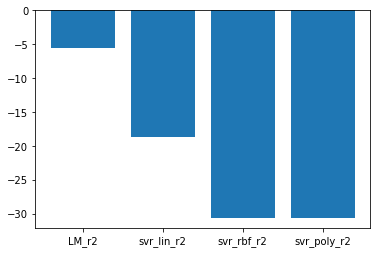

In [43]:
c_val = 0.1
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
svr_lin_pred = svr_lin.fit(X_train,Y_train).predict(X_test)
svr_rbf_pred = svr_rbf.fit(X_train,Y_train).predict(X_test)
svr_poly_pred = svr_rbf.fit(X_train,Y_train).predict(X_test)
X_test.reset_index(inplace = True)
X_test.drop(columns = [X_test.columns[0]],inplace = True)
print(len(LM_pred))
print(X_test)
# plt.scatter(X_test["DEXJPUS"],LM_pred, c='magenta')
# plt.show()
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
LM_r2 = metrics.r2_score(Y_test, LM_pred)
print (LM_MSE)
print(LM_r2)

svr_lin_MSE = metrics.mean_squared_error(Y_test, svr_lin_pred)
svr_lin_r2 = metrics.r2_score(Y_test, svr_lin_pred)
print (svr_lin_MSE)
print(svr_lin_r2)


svr_rbf_MSE = metrics.mean_squared_error(Y_test, svr_rbf_pred)
svr_rbf_r2 = metrics.r2_score(Y_test, svr_rbf_pred)
print (svr_rbf_MSE)
print(svr_rbf_r2)

svr_poly_MSE = metrics.mean_squared_error(Y_test, svr_poly_pred)
svr_poly_r2 = metrics.r2_score(Y_test, svr_poly_pred)
print (svr_poly_MSE)
print(svr_poly_r2)

# plt.bar(["LM_MSE","svr_lin_MSE","svr_rbf_MSE","svr_poly_MSE"],[LM_MSE,svr_lin_MSE,svr_rbf_MSE,svr_poly_MSE])
plt.bar(["LM_r2","svr_lin_r2","svr_rbf_r2","svr_poly_r2"],[LM_r2,svr_lin_r2,svr_rbf_r2,svr_poly_r2])
plt.show()